In [16]:
import _init_paths
import os
import argparse
import torch
import subprocess
from vcr.function.config import config, update_config
from vcr.function.train import train_net
from vcr.function.test import test_net
import ipdb
from vcr.modules.resnet_vlbert_for_vcr import ResNetVLBERT
from PIL import Image
from PIL import ImageDraw
import math

from PIL import ImageFont
import requests
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);




parser = argparse.ArgumentParser('Train Cognition Network')
parser.add_argument('--cfg', type=str, default='../cfgs/vcr/base_q2a_4x16G_fp32.yaml')
parser.add_argument('--model-dir', type=str, help='root path to store checkpoint')
parser.add_argument('--log-dir', type=str, help='tensorboard log dir')
parser.add_argument('--dist', help='whether to use distributed training', default=False, action='store_true')
parser.add_argument('--slurm', help='whether this is a slurm job', default=False, action='store_true')
parser.add_argument('--do-test', help='whether to generate csv result on test set',
                    default=False, action='store_true')
parser.add_argument('--cudnn-off', help='disable cudnn', default=False, action='store_true')

# easy test pretrain model
parser.add_argument('--partial-pretrain', type=str)

parser.add_argument('--lr', default=1e-4, type=float)
parser.add_argument('--lr_backbone', default=1e-5, type=float)
parser.add_argument('--batch_size', default=2, type=int)
parser.add_argument('--weight_decay', default=1e-4, type=float)
parser.add_argument('--epochs', default=300, type=int)
parser.add_argument('--lr_drop', default=200, type=int)
parser.add_argument('--clip_max_norm', default=0.1, type=float,
                    help='gradient clipping max norm')

# Model parameters
parser.add_argument('--frozen_weights', type=str, default=None,
                    help="Path to the pretrained model. If set, only the mask head will be trained")
# * Backbone
parser.add_argument('--backbone', default='resnet50', type=str,
                    help="Name of the convolutional backbone to use")
parser.add_argument('--dilation', action='store_true',
                    help="If true, we replace stride with dilation in the last convolutional block (DC5)")
parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                    help="Type of positional embedding to use on top of the image features")

# * Transformer
parser.add_argument('--enc_layers', default=6, type=int,
                    help="Number of encoding layers in the transformer")
parser.add_argument('--dec_layers', default=6, type=int,
                    help="Number of decoding layers in the transformer")
parser.add_argument('--dim_feedforward', default=2048, type=int,
                    help="Intermediate size of the feedforward layers in the transformer blocks")
parser.add_argument('--hidden_dim', default=256, type=int,
                    help="Size of the embeddings (dimension of the transformer)")
parser.add_argument('--dropout', default=0.1, type=float,
                    help="Dropout applied in the transformer")
parser.add_argument('--nheads', default=8, type=int,
                    help="Number of attention heads inside the transformer's attentions")
parser.add_argument('--num_queries', default=100, type=int,
                    help="Number of query slots")
parser.add_argument('--pre_norm', action='store_true')

# * Segmentation
parser.add_argument('--masks', action='store_true',
                    help="Train segmentation head if the flag is provided")

# Loss
parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                    help="Disables auxiliary decoding losses (loss at each layer)")
# * Matcher
parser.add_argument('--set_cost_class', default=1, type=float,
                    help="Class coefficient in the matching cost")
parser.add_argument('--set_cost_bbox', default=5, type=float,
                    help="L1 box coefficient in the matching cost")
parser.add_argument('--set_cost_giou', default=2, type=float,
                    help="giou box coefficient in the matching cost")
# * Loss coefficients
parser.add_argument('--mask_loss_coef', default=1, type=float)
parser.add_argument('--dice_loss_coef', default=1, type=float)
parser.add_argument('--bbox_loss_coef', default=5, type=float)
parser.add_argument('--giou_loss_coef', default=2, type=float)
parser.add_argument('--eos_coef', default=0.1, type=float,
                    help="Relative classification weight of the no-object class")

# dataset parameters
parser.add_argument('--dataset_file', default='coco')
parser.add_argument('--coco_path', type=str)
parser.add_argument('--coco_panoptic_path', type=str)
parser.add_argument('--remove_difficult', action='store_true')

parser.add_argument('--output_dir', default='',
                    help='path where to save, empty for no saving')
parser.add_argument('--device', default='cuda',
                    help='device to use for training / testing')
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--resume', default='', help='resume from checkpoint')
parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                    help='start epoch')
parser.add_argument('--eval', action='store_true')
parser.add_argument('--num_workers', default=2, type=int)

# distributed training parameters
parser.add_argument('--world_size', default=1, type=int,
                    help='number of distributed processes')
parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
args = parser.parse_args(args=[])

if args.cfg is not None:
    update_config(args.cfg)
if args.model_dir is not None:
    config.OUTPUT_PATH = os.path.join(args.model_dir, config.OUTPUT_PATH)

if args.partial_pretrain is not None:
    config.NETWORK.PARTIAL_PRETRAIN = args.partial_pretrain

if args.slurm:
    proc_id = int(os.environ['SLURM_PROCID'])
    ntasks = int(os.environ['SLURM_NTASKS'])
    node_list = os.environ['SLURM_NODELIST']
    num_gpus = torch.cuda.device_count()
    addr = subprocess.getoutput(
        'scontrol show hostname {} | head -n1'.format(node_list))
    os.environ['MASTER_PORT'] = str(29500)
    os.environ['MASTER_ADDR'] = addr
    os.environ['WORLD_SIZE'] = str(ntasks)
    os.environ['RANK'] = str(proc_id)
    os.environ['LOCAL_RANK'] = str(proc_id % num_gpus)


  

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def plot_results_(img, im_name, boxes):
    a=ImageDraw.ImageDraw(img)
    for box in boxes:
        x1,y1,x2,y2 = box
        a.rectangle((int(x1),int(y1),int(x2),int(y2)))
    img.save(im_name)

/mnt/diskb/qu_tang/detr-vlbert/viz/../vcr/function/config.py:180: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


In [19]:
model_path = '/mnt/diskb/qu_tang/detr-vlbert/vcr_test/output/vl-bert/vcr/base_q2a_4x16G_fp32/vcr1images_train/vl-bert_base_a_res101-best.model'
img_path = '/mnt/diskb/qu_tang/detr-vlbert/data/vcr/vcr1images/movieclips_Young_Sherlock_Holmes/-kRGB8yBnrA@27.jpg'

In [24]:
model = ResNetVLBERT(args,config)
model_detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model_detr.eval()

state_dict = torch.load(model_path,map_location="cpu")['state_dict']
#state_dict = torch.load(model_path)['state_dict']
state_dict = {k[7:]:state_dict[k] for k in state_dict}
model.load_state_dict(state_dict)
model.eval()
im = Image.open(img_path)
img = transform(im).unsqueeze(0)

outputs = model.image_feature_extractor.forward_img(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

outputs_detr = model_detr(img)
probas_detr = outputs_detr['pred_logits'].softmax(-1)[0, :, :-1]
keep_detr = probas_detr.max(-1).values > 0.9
bboxes_scaled_detr = rescale_bboxes(outputs_detr['pred_boxes'][0, keep_detr], im.size)

plot_results(im, probas[keep], bboxes_scaled)
im = Image.open(img_path)
plot_results(im, probas_detr[keep_detr], bboxes_scaled_detr)
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
model.image_feature_extractor.backbone[-2].register_forward_hook(
    lambda self, input, output: conv_features.append(output)
),
model.image_feature_extractor.transformer.encoder.layers[-1].self_attn.register_forward_hook(
    lambda self, input, output: enc_attn_weights.append(output[1])
),
model.image_feature_extractor.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
    lambda self, input, output: dec_attn_weights.append(output[1])
),
]

# propagate through the model
outputs = model.image_feature_extractor.forward_img(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]


Model name './model/pretrained_model/bert-base-uncased' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed './model/pretrained_model/bert-base-uncased' was a path or url but couldn't find any file associated to this path or url.


Using cache found in /home/qu_tang/.cache/torch/hub/facebookresearch_detr_master


In [20]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [31]:
%matplotlib inline

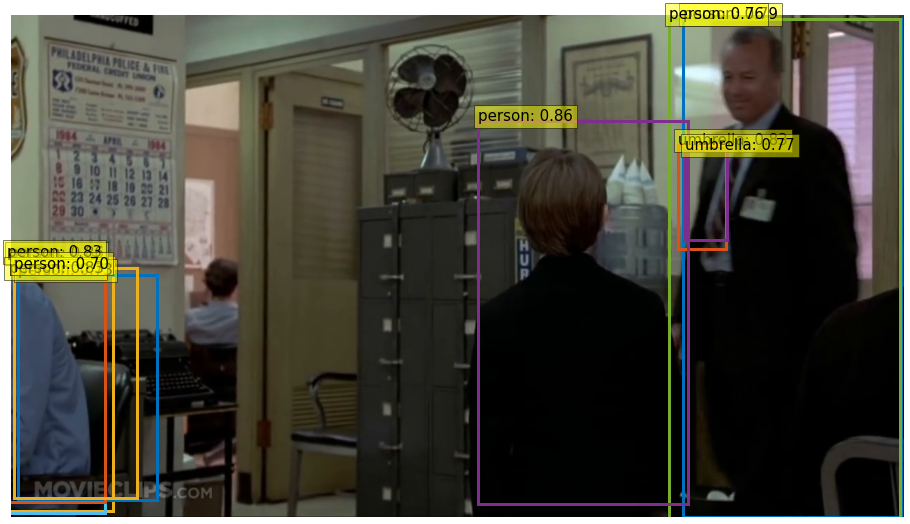

In [89]:
plot_results(im, probas[keep], bboxes_scaled)

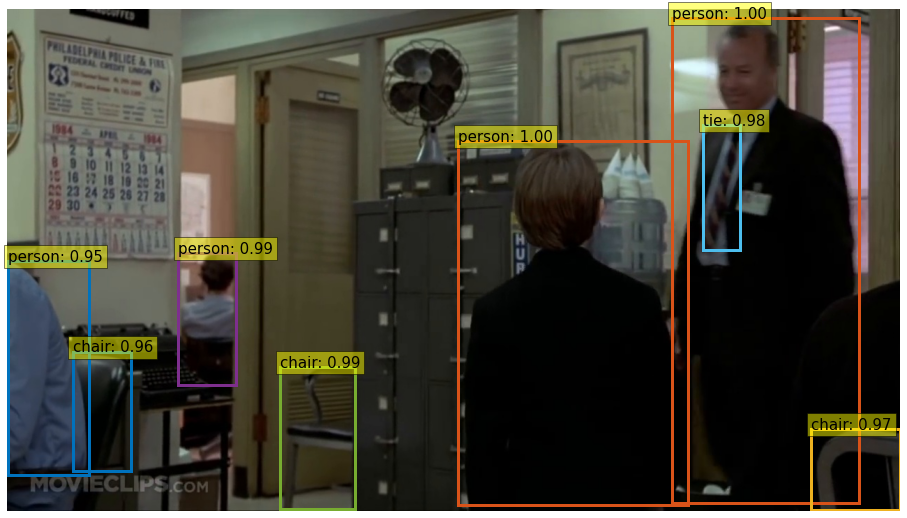

In [90]:
plot_results(im, probas_detr[keep_detr], bboxes_scaled_detr)

In [86]:
model = ResNetVLBERT(args,config)
model_path = '/mnt/diskb/qu_tang/detr-vlbert/vcr_test/E3/vl-bert_base_a_res101-best.model'
state_dict = torch.load(model_path,map_location="cpu")['state_dict']
#state_dict = torch.load(model_path)['state_dict']
state_dict = {k[7:]:state_dict[k] for k in state_dict}
model.load_state_dict(state_dict)
model.eval()

Model name './model/pretrained_model/bert-base-uncased' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed './model/pretrained_model/bert-base-uncased' was a path or url but couldn't find any file associated to this path or url.


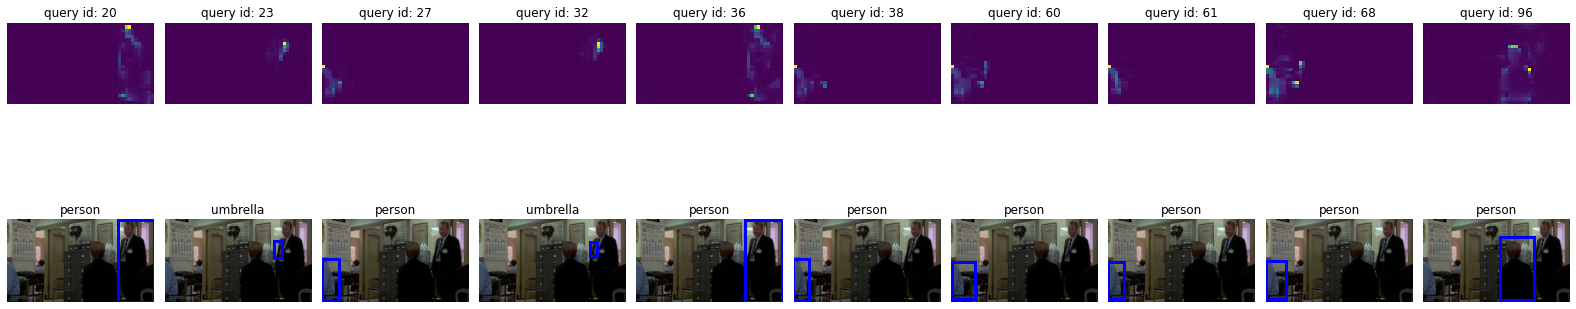

In [88]:
img_path = '/mnt/diskb/qu_tang/detr-vlbert/data/vcr/vcr1images/movieclips_Witness/LmdcbtSwX6Q@2.jpg'
im = Image.open(img_path)
img = transform(im).unsqueeze(0)
outputs = model.image_feature_extractor.forward_img(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
model.image_feature_extractor.backbone[-2].register_forward_hook(
    lambda self, input, output: conv_features.append(output)
),
model.image_feature_extractor.transformer.encoder.layers[-1].self_attn.register_forward_hook(
    lambda self, input, output: enc_attn_weights.append(output[1])
),
model.image_feature_extractor.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
    lambda self, input, output: dec_attn_weights.append(output[1])
),
]

# propagate through the model
outputs = model.image_feature_extractor.forward_img(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]
fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

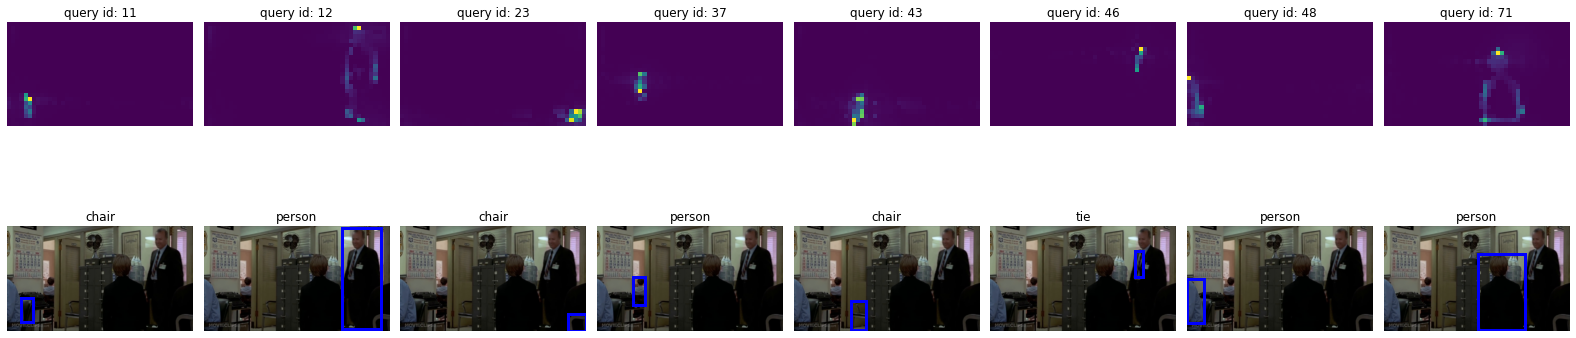

In [87]:
img_path = '/mnt/diskb/qu_tang/detr-vlbert/data/vcr/vcr1images/movieclips_Witness/LmdcbtSwX6Q@2.jpg'
im = Image.open(img_path)
img = transform(im).unsqueeze(0)
outputs_detr = model_detr(img)
probas_detr = outputs_detr['pred_logits'].softmax(-1)[0, :, :-1]
keep_detr = probas_detr.max(-1).values > 0.9
bboxes_scaled_detr = rescale_bboxes(outputs_detr['pred_boxes'][0, keep_detr], im.size)
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
model_detr.backbone[-2].register_forward_hook(
    lambda self, input, output: conv_features.append(output)
),
model_detr.transformer.encoder.layers[-1].self_attn.register_forward_hook(
    lambda self, input, output: enc_attn_weights.append(output[1])
),
model_detr.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
    lambda self, input, output: dec_attn_weights.append(output[1])
),
]

# propagate through the model
outputs = model_detr(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled_detr), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep_detr.nonzero(), axs.T, bboxes_scaled_detr):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas_detr[idx].argmax()])
fig.tight_layout()